## Application: Wage and Education

#### Variables:

+ work - participation in 1975 ?
+ hoursw - wife's hours of work in 1975
+ child6 - number of children less than 6 years old in household
+ child618 - number of children between ages 6 and 18 in household
+ agew - wife's age
+ educw - wife's educational attainment, in years
+ hearnw - wife's average hourly earnings, in 1975 dollars
+ wagew - wife's wage reported at the time of the 1976 interview (not= 1975 estimated wage)
+ hoursh - husband's hours worked in 1975
+ ageh - husband's age
+ educh - husband's educational attainment, in years
+ wageh - husband's wage, in 1975 dollars
+ income - family income, in 1975 dollars
+ educwm - wife's mother's educational attainment, in years
+ educwf - wife's father's educational attainment, in years
+ unemprate - unemployment rate in county of residence, in percentage points
+ city - lives in large city (SMSA) ?
+ experience - actual years of wife's previous labor market experience

#### Source:

Mroz - Labor Supply Data

https://vincentarelbundock.github.io/Rdatasets/datasets.html

Mroz, T. (1987) “The sensitivity of an empirical model of married women's hours of work to economic and statistical assumptions”, Econometrica, 55, 765-799.


In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
from IPython.display import display
from numpy.linalg import lstsq

#### Data retrieval

`read_csv` creates a Pandas dataframe by retrieving data from a CSV file.

```Python
    read_csv(file name, option 1, option 2, ...)
```

`index_col=0` implies that the first column of the CSV file is used as the index of observations.


In [2]:
data = pd.read_csv('Mroz.csv', index_col=0)
wage = data['wagew'].values
educ = data['educw'].values
y = wage[wage > 0]
x = educ[wage > 0] - 12
ols_b = lstsq(np.vstack((np.ones(x.size), x)).T, y, rcond=None)[0]

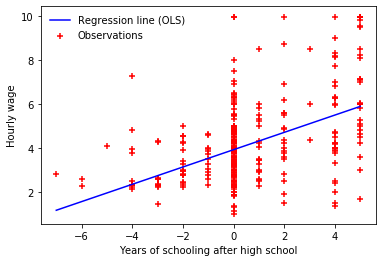

In [3]:
fig1 = plt.figure(num=1, facecolor='w')
plt.scatter(x, y, color='r', marker='+', label='Observations')
x_range = (np.min(x), np.max(x))
y_range = (ols_b[0] + ols_b[1]*x_range[0], ols_b[0] + ols_b[1]*x_range[1])
plt.plot(x_range, y_range, 'b-', label='Regression line (OLS)')
plt.xlabel('Years of schooling after high school')
plt.ylabel('Hourly wage')
plt.legend(loc='upper left', frameon=False)
# plt.savefig('ms_fig_wage_education.png', dpi=300)
plt.show()

In [4]:
mu_a = 0.0
mu_b = 0.0
omega_a = 10.0
omega_b = 10.0
nu0 = 0.02
lam0 = 0.02

In [5]:
regresssion_normal_invgamma = pm.Model()
with regresssion_normal_invgamma:
    sigma2 = pm.InverseGamma('sigma2', alpha=0.5*nu0, beta=0.5*lam0)
    a = pm.Normal('a', mu=mu_a, sd=omega_a)
    b = pm.Normal('b', mu=mu_b, sd=omega_b)
    y_hat = a + b * x
    likelihood = pm.Normal('y', mu=y_hat, sd=pm.math.sqrt(sigma2), observed=y)

In [6]:
n_draws = 5000
n_chains = 4
n_tune = 1000
with regresssion_normal_invgamma:
    trace = pm.sample(draws=n_draws, chains=n_chains, tune=n_tune, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, sigma2]
Sampling 4 chains: 100%|██████████| 24000/24000 [00:03<00:00, 6707.14draws/s]


In [7]:
display(pm.summary(trace))

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,3.912732,0.094729,0.000514,3.720651,4.094927,22917.279274,0.999944
b,0.394372,0.039923,0.000231,0.313516,0.470949,26881.942491,0.999914
sigma2,2.815412,0.219063,0.001330,2.392937,3.244563,27654.860778,0.999963


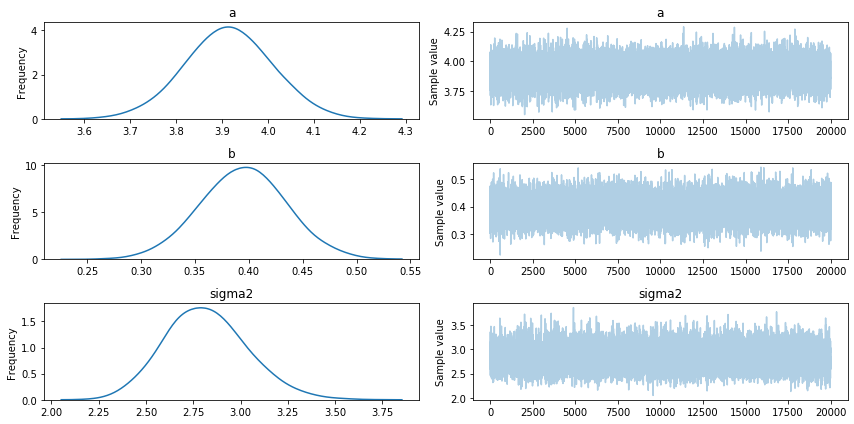

In [8]:
ax2 = pm.traceplot(trace, combined=True)

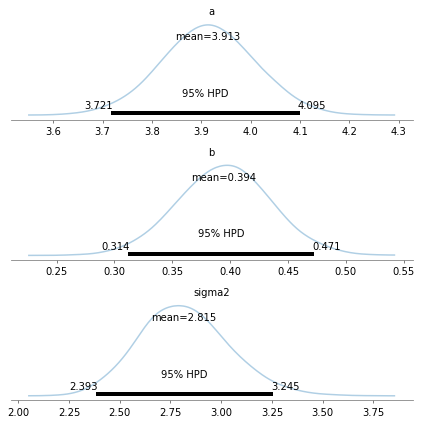

In [9]:
fig3, ax3 = plt.subplots(3, 1, num=3, facecolor='w', figsize=(6, 6))
ax3 = pm.plot_posterior(trace, ax=ax3, kde_plot=True, point_estimate='mean')